<a href="https://colab.research.google.com/github/imnawar/AnnArabic/blob/master/STL/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow
tensorflow


In [16]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.optimizers import Adam
import os
import pickle
import numpy as np

In [3]:
from __future__ import print_function

import sys
import os, sys, tarfile, errno
import numpy as np
import matplotlib.pyplot as plt
    
if sys.version_info >= (3, 0, 0):
    import urllib.request as urllib # ugly but works
else:
    import urllib

try:
    from imageio import imsave
except:
    from scipy.misc import imsave

print(sys.version_info) 

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

# path to the binary train file with image data
DATA_PATH = './data/stl10_binary/train_X.bin'

# path to the binary train file with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image


def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()

def save_image(image, name):
    imsave("%s.png" % name, image, format="png")

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

def save_images(images, labels):
    print("Saving images to disk")
    i = 0
    for image in images:
        label = labels[i]
        directory = './img/' + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        print(filename)
        save_image(image, filename)
        i = i+1
    
if __name__ == "__main__":
    # download data if needed
    download_and_extract()

#     # test to check if the image is read correctly
#     with open(DATA_PATH) as f:
#         image = read_single_image(f)
#         plot_image(image)

#     # test to check if the whole dataset is read correctly
#     images = read_all_images(DATA_PATH)
#     print(images.shape)

#     labels = read_labels(LABEL_PATH)
#     print(labels.shape)

#     # save images to disk
#     save_images(images, labels)

sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)


In [4]:
batch_size = 32
num_classes = 10
epochs = 100
saveDir = "/opt/files/python/transfer/ae/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [5]:
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = read_all_images('/content/data/stl10_binary/train_X.bin')
x_test = read_all_images('/content/data/stl10_binary/test_X.bin')
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')

In [6]:
# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	X = read_all_images('/content/data/stl10_binary/test_X.bin')
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = X / 127.5 - 1.
	return X

In [7]:
# normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [8]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (5000, 96, 96, 3)
5000 train samples
8000 test samples


In [9]:
# divide x_test into validation and test
x_val = x_test[:3000]
x_test = x_test[3000:]

In [10]:
noise_factor = 0.1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)

In [17]:
# definition to show original image and reconstructed image
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(96, 96, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display original
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(96, 96, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

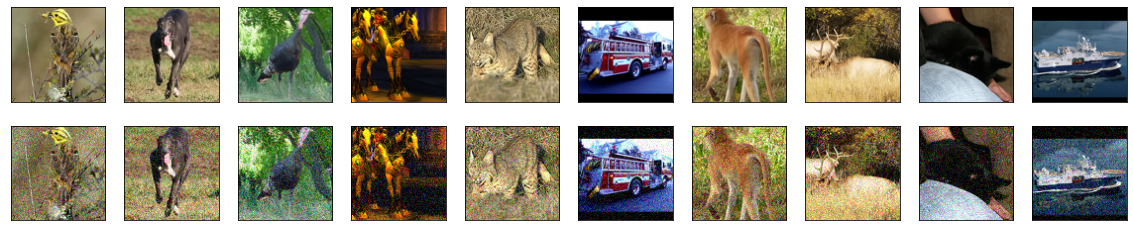

In [18]:
showOrigDec(x_train, x_train_noisy)

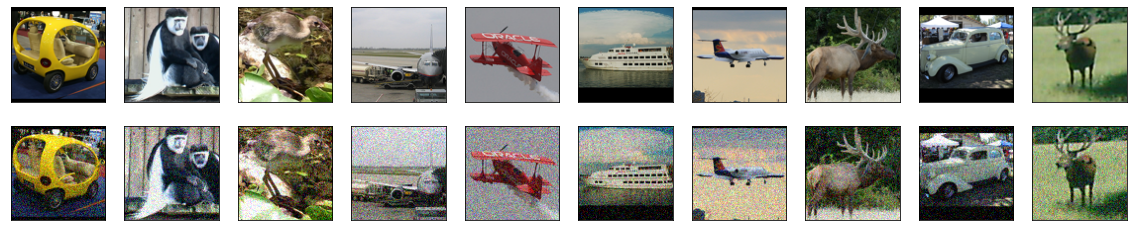

In [19]:
showOrigDec(x_train[100:], x_train_noisy[100:])

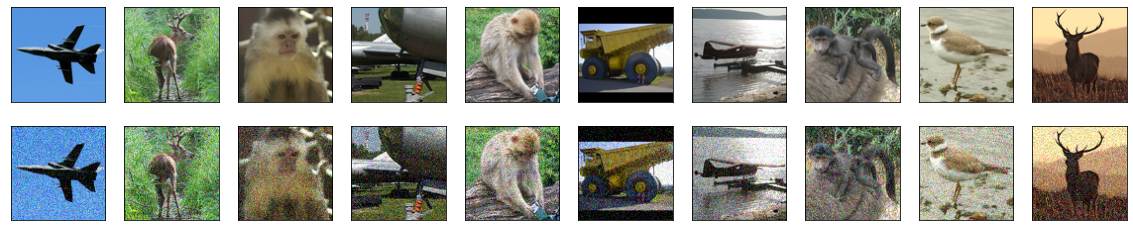

In [20]:
showOrigDec(x_train[200:], x_train_noisy[200:])

In [21]:
input_img = Input(shape=(96, 96, 3))
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [22]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')

In [23]:
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = saveDir + 'AutoEncoder_Cifar10_denoise_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [24]:
history = model.fit(x_train_noisy, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val_noisy, x_val),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 0.5647
Epoch 00001: val_loss improved from inf to 0.62765, saving model to /opt/files/python/transfer/ae/AutoEncoder_Cifar10_denoise_weights.01-0.56-0.63.hdf5
157/157 [==============================] - 224s 1s/step - loss: 0.5647 - val_loss: 0.6276
Epoch 2/100
157/157 [==============================] - ETA: 0s - loss: 0.5463
Epoch 00002: val_loss improved from 0.62765 to 0.56023, saving model to /opt/files/python/transfer/ae/AutoEncoder_Cifar10_denoise_weights.02-0.55-0.56.hdf5
157/157 [==============================] - 216s 1s/step - loss: 0.5463 - val_loss: 0.5602
Epoch 3/100
157/157 [==============================] - ETA: 0s - loss: 0.5408
Epoch 00003: val_loss improved from 0.56023 to 0.53949, saving model to /opt/files/python/transfer/ae/AutoEncoder_Cifar10_denoise_weights.03-0.54-0.54.hdf5
157/157 [==============================] - 216s 1s/step - loss: 0.5408 - val_loss: 0.5395
Epoch 4/100
157/157 [===========

In [25]:
score = model.evaluate(x_test_noisy, x_test, verbose=1)
print(score)

157/157 [==============================] - 50s 320ms/step - loss: 0.5308
0.5308367013931274


In [26]:
c10test = model.predict(x_test_noisy)
c10val = model.predict(x_val_noisy)

In [27]:
print("Cifar10_test: {0}\nCifar10_val: {1}".format(np.average(c10test), np.average(c10val)))

Cifar10_test: 0.4285256564617157
Cifar10_val: 0.4313340187072754


In [32]:
model

In [33]:
# definition to show original image and reconstructed image
def showOrigDec(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(orig[i].reshape(96, 96, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        plt.imshow(noise[i].reshape(96, 96, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        plt.imshow(denoise[i].reshape(96, 96, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

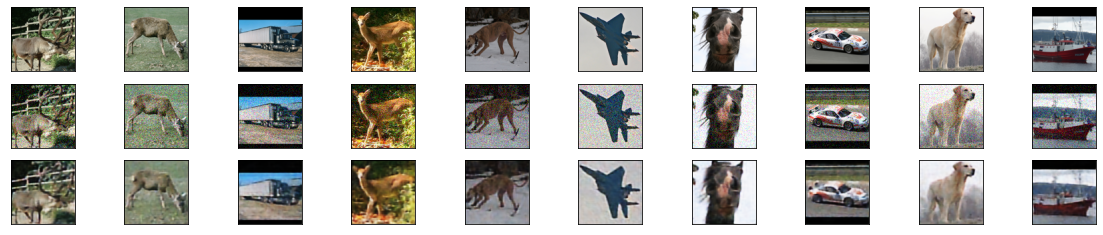

In [34]:
showOrigDec(x_test, x_test_noisy, c10test)

In [35]:
encoder_model = Model(input_img, encoded)

In [40]:
model.weights

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[-6.45568520e-02, -1.48806676e-01, -7.35991150e-02,
           -5.40821776e-02,  9.26746130e-02,  7.03986958e-02,
            2.81255078e-02,  7.46294260e-02, -1.46056026e-01,
            6.58041537e-02,  4.31353301e-02, -4.43121195e-02,
           -5.47792651e-02,  1.40651345e-01, -1.19573139e-01,
            5.83343580e-03,  1.00330256e-01,  6.57232404e-02,
           -7.35075772e-02,  2.07644757e-02, -9.20770541e-02,
           -7.24622160e-02,  5.04943468e-02, -8.19206759e-02,
           -2.56279949e-02, -8.55066627e-02,  9.33804959e-02,
           -1.39535321e-02,  1.25988975e-01,  1.87569112e-03,
            7.39193931e-02, -2.47115698e-02],
          [ 2.65084300e-02, -9.67999995e-02,  1.45546049e-02,
            2.28362177e-02,  9.16909203e-02, -7.50147104e-02,
           -8.39841142e-02,  1.02875195e-01, -1.09170653e-01,
           -1.56546429e-01,  1.80529021e-02,  9.44125056e-02,
           -

In [39]:
encoder_model.weights

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[-6.45568520e-02, -1.48806676e-01, -7.35991150e-02,
           -5.40821776e-02,  9.26746130e-02,  7.03986958e-02,
            2.81255078e-02,  7.46294260e-02, -1.46056026e-01,
            6.58041537e-02,  4.31353301e-02, -4.43121195e-02,
           -5.47792651e-02,  1.40651345e-01, -1.19573139e-01,
            5.83343580e-03,  1.00330256e-01,  6.57232404e-02,
           -7.35075772e-02,  2.07644757e-02, -9.20770541e-02,
           -7.24622160e-02,  5.04943468e-02, -8.19206759e-02,
           -2.56279949e-02, -8.55066627e-02,  9.33804959e-02,
           -1.39535321e-02,  1.25988975e-01,  1.87569112e-03,
            7.39193931e-02, -2.47115698e-02],
          [ 2.65084300e-02, -9.67999995e-02,  1.45546049e-02,
            2.28362177e-02,  9.16909203e-02, -7.50147104e-02,
           -8.39841142e-02,  1.02875195e-01, -1.09170653e-01,
           -1.56546429e-01,  1.80529021e-02,  9.44125056e-02,
           -

In [36]:
encoder_model(np.expand_dims(x_test[0], 0))

<tf.Tensor: shape=(1, 24, 24, 32), dtype=float32, numpy=
array([[[[9.2717612e-01, 1.3304172e+00, 1.6581598e-03, ...,
          1.5856596e+00, 1.1230594e+00, 1.8852587e+00],
         [8.1923664e-01, 1.3083148e+00, 0.0000000e+00, ...,
          1.3271868e+00, 7.2509861e-01, 1.8778558e+00],
         [7.3257226e-01, 1.2798837e+00, 0.0000000e+00, ...,
          1.3326160e+00, 5.4579449e-01, 1.7921543e+00],
         ...,
         [9.9194187e-01, 1.9194561e+00, 0.0000000e+00, ...,
          1.3026470e+00, 1.8049253e+00, 1.0271552e+00],
         [2.3082623e+00, 7.3603159e-01, 0.0000000e+00, ...,
          1.1307031e+00, 1.0678474e+00, 1.3995334e+00],
         [7.6387388e-01, 1.4939346e+00, 7.3874116e-01, ...,
          8.2549942e-01, 1.7780612e+00, 4.9633321e-01]],

        [[9.4669455e-01, 1.3303226e+00, 2.6524309e-02, ...,
          1.5242293e+00, 1.1335640e+00, 1.2778982e+00],
         [7.3721069e-01, 1.3731259e+00, 0.0000000e+00, ...,
          1.1618037e+00, 4.1099051e-01, 1.2908252e+00],

In [37]:
np.expand_dims(x_test[0], 0).shape

(1, 96, 96, 3)

In [41]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open("AE.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("AE.h5")

In [38]:
# keras library import  for Saving and loading model and weights

from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = encoder_model.to_json()


with open("encoder.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
encoder_model.save_weights("encoder.h5")